# Fairness analysis and mitigation
## In this dataset, we used the Fairlearn library to analyze fairness metrics and attempted to mitigate biases.

In [128]:
import pandas as pd
data_filtered = pd.read_csv("adult_preprocessed.csv")

In [2]:
data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30162 entries, 0 to 30161
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             30162 non-null  int64 
 1   workclass       30162 non-null  object
 2   education.num   30162 non-null  int64 
 3   marital.status  30162 non-null  object
 4   occupation      30162 non-null  object
 5   relationship    30162 non-null  object
 6   race            30162 non-null  object
 7   sex             30162 non-null  object
 8   hours.per.week  30162 non-null  int64 
 9   income          30162 non-null  object
 10  region          30162 non-null  object
dtypes: int64(3), object(8)
memory usage: 2.5+ MB


## Fairness pipeline using *fairlearn*

In [40]:
import pandas as pd
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import set_config
import torch
from math import sqrt
from fairlearn.metrics import MetricFrame, demographic_parity_difference
from sklearn.metrics import accuracy_score
from numpy import mean
from fairlearn.adversarial import AdversarialFairnessClassifier
from fairlearn.datasets import fetch_adult
from fairlearn.metrics import MetricFrame, selection_rate

def run_fairness_pipeline(dataset, sensitive_feature,schedulers=[]):
    """
    Runs the fairness pipeline for a given dataset and sensitive feature.

    Parameters:
    - dataset: DataFrame containing the dataset.
    - sensitive_feature: str, name of the sensitive feature column (e.g., 'sex', 'region', 'race').
    - target_column: str, name of the target column. Default is 'income'.
    """

    # Split features and target
    X = dataset.drop(columns=["income"])  # Replace "income" with your target column name
    y = dataset["income"]
    z = X[sensitive_feature]  # Set the sensitive feature

    # Train-test split
    X_train, X_test, y_train, y_test, Z_train, Z_test = train_test_split(
        X, y, z, test_size=0.2, random_state=12345, stratify=y
    )

    # Enable sklearn metadata routing
    set_config(enable_metadata_routing=True)

    # Define column transformers
    ct = make_column_transformer(
        (
            Pipeline(
                [
                    ("imputer", SimpleImputer(strategy="mean")),
                    ("normalizer", StandardScaler()),
                ]
            ),
            make_column_selector(dtype_include="number"),
        ),
        (
            Pipeline(
                [
                    ("imputer", SimpleImputer(strategy="most_frequent")),
                    ("encoder", OneHotEncoder(drop="if_binary", sparse_output=False)),
                ]
            ),
            make_column_selector(dtype_include="category"),
        ),
    )

    X_train_transformed = ct.fit_transform(X_train)
    in_features = X_train_transformed.shape[1]

    # Define Predictor Model
    class PredictorModel(torch.nn.Module):
        def __init__(self, in_features):
            super(PredictorModel, self).__init__()
            self.layers = torch.nn.Sequential(
                torch.nn.Linear(in_features=in_features, out_features=200),
                torch.nn.LeakyReLU(),
                torch.nn.Linear(in_features=200, out_features=1),
                torch.nn.Sigmoid(),
            )

        def forward(self, x):
            return self.layers(x)

    predictor_model = PredictorModel(in_features=in_features)

    def validate(pipeline, X, y, z, pos_label):
        predictions = pipeline.predict(X)
        dp_diff = demographic_parity_difference(
            y == pos_label,
            predictions == pos_label,
            sensitive_features=z,
        )
        accuracy = mean(predictions == y.values)
        selection_rate = mean(predictions == pos_label)
        print(
            f"Sensitive Feature: {sensitive_feature}, DP diff: {dp_diff:.4f}, accuracy: {accuracy:.4f}, selection_rate: {selection_rate:.4f}"
        )
        return dp_diff, accuracy, selection_rate

    schedulers = []

    def optimizer_constructor(model):
        #global schedulers
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
        schedulers.append(torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.995))
        return optimizer

    def callbacks(model, step, X, y, z, pos_label):
        #global schedulers
        model.alpha = 0.3 * sqrt(step // 1)
        for scheduler in schedulers:
            scheduler.step()
        if step % 50 == 0:
            dp_diff, accuracy, selection_rate = validate(model, X, y, z, pos_label)
            if dp_diff < 0.03 and accuracy > 0.8 and 0.01 < selection_rate < 0.99:
                return True

    mitigator = AdversarialFairnessClassifier(
        predictor_model=predictor_model,
        adversary_model=[3, "leaky_relu"],
        predictor_optimizer=optimizer_constructor,
        adversary_optimizer=optimizer_constructor,
        epochs=10,
        batch_size=2**7,
        shuffle=True,
        callbacks=callbacks,
        random_state=123,
    )

    pipeline = make_pipeline(ct, mitigator.set_fit_request(sensitive_features=True))
    pipeline.fit(X_train, y_train, sensitive_features=Z_train)

    # Define the positive label for validation
    _, labelget = fetch_adult(return_X_y=True)
    pos_label = labelget[2]  # positive = >50k
    print("positive label:", pos_label)
    z = X[sensitive_feature]  # In this example, we consider 'sex' the sensitive feature.
    # to see DP difference, accuracy, and selection_rate
    print(validate(pipeline, X_test, y_test, z=Z_test, pos_label=pos_label))
    # Validate the pipeline
    validate(pipeline, X_test, y_test, z=Z_test, pos_label=pos_label)

    # Predictions and metrics
    predictions = pipeline.predict(X_test)
    mf = MetricFrame(
        metrics={"accuracy": accuracy_score, "selection_rate": selection_rate},
        y_true=y_test == pos_label,
        y_pred=predictions == pos_label,
        sensitive_features=Z_test,
    )
    print(mf.by_group)

    set_config(enable_metadata_routing=False)

### First let's analyze the fairlearn metrics and evaluations for the sensitive features *sex*, *region*, and *race*

In [24]:
run_fairness_pipeline(data_filtered, sensitive_feature="sex")

Sensitive Feature: sex, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: sex, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: sex, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: sex, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: sex, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: sex, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: sex, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: sex, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: sex, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: sex, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: sex, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: sex, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Featur

In [26]:
# For 'race' as the sensitive feature
run_fairness_pipeline(data_filtered, sensitive_feature="race")


Sensitive Feature: race, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: race, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: race, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: race, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: race, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: race, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: race, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: race, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: race, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: race, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: race, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: race, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sens

In [96]:
# For 'region' as the sensitive feature
run_fairness_pipeline(data_filtered, sensitive_feature="region")


Sensitive Feature: region, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: region, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: region, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: region, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: region, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: region, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: region, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: region, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: region, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: region, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: region, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: region, DP diff: 0.0000, accuracy: 0.0000, sel

## From the analysis of DP diff and selection rate, we observe that:
### For the sensitive feature "race", "Black" and "Other" groups are experiencing bias compared to other groups.
### In "sex", men have almost double the selection rate compared to women, favoring the male gender.
### In "region", the DP diff is significantly higher (0.249), indicating low fairness.
#### Although "Latin America" has a higher selection rate, it also shows very low accuracy (0.55), indicating less reliable predictions.

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

## Let's try augmenting data
## Our goal here is to fight against class imbalance to have better prediction models and increase fairness

## Approach no.1:
### Let's try balancing all sensite features so they have the same row count for each value.

In [28]:
import pandas as pd

# Check if the necessary columns exist
if 'region' in data_filtered.columns and 'race' in data_filtered.columns:
    # Group by 'region' and 'race', then count occurrences
    region_race_counts = data_filtered.groupby(['region', 'race']).size().reset_index(name='count')

    # Calculate the total occurrences for each region
    region_totals = data_filtered['region'].value_counts().reset_index()
    region_totals.columns = ['region', 'total']

    # Merge the total counts back into the grouped data
    region_race_counts = region_race_counts.merge(region_totals, on='region')

    # Calculate the percentage of each 'race' within each 'region'
    region_race_counts['percentage'] = (region_race_counts['count'] / region_race_counts['total']) * 100

    # Sort and display the results
    region_race_counts = region_race_counts.sort_values(by=['region', 'percentage'], ascending=[True, False])
    print(region_race_counts)

else:
    print("The required columns 'region' and 'race' are not present in the dataset.")


           region                race  count  total  percentage
0            Asia  Asian-Pac-Islander    540    634   85.173502
3            Asia               White     78    634   12.302839
2            Asia               Other     10    634    1.577287
1            Asia               Black      6    634    0.946372
7          Europe               White    470    493   95.334686
5          Europe               Black     14    493    2.839757
4          Europe  Asian-Pac-Islander      7    493    1.419878
6          Europe               Other      2    493    0.405680
11  Latin America               White   1053   1297   81.187355
9   Latin America               Black    121   1297    9.329221
10  Latin America               Other    118   1297    9.097918
8   Latin America  Asian-Pac-Islander      5   1297    0.385505
12          Other  Asian-Pac-Islander     69    127   54.330709
13          Other               Black     47    127   37.007874
15          Other               White   

## Let's use SDV, which is a tool that creates synthetic data learning from existing data, making it so that it does not change the original dataset information

In [5]:
from sdv.metadata import SingleTableMetadata

# Initialize metadata
metadata = SingleTableMetadata()

# Detect the data types and relationships
metadata.detect_from_dataframe(data_filtered)


In [6]:
from sdv.single_table import CTGANSynthesizer

# Initialize the synthesizer
synthesizer = CTGANSynthesizer(metadata)


C:\Users\Rafa Parkoureiro\anaconda3\envs\IAS\Lib\site-packages\sdv\single_table\base.py:119: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
C:\Users\Rafa Parkoureiro\anaconda3\envs\IAS\Lib\site-packages\sdv\single_table\base.py:104: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


In [7]:
data_filtered2 = data_filtered.copy()  # Ensure it's a copy of a DataFrame


In [8]:
# Train the synthesizer
synthesizer.fit(data_filtered2)


In [9]:
#synthesizer.save(
#    filepath='my_synthesizer2.pkl'
#)

### I created a conditional synthetic data conditions so data created goes accordingly to our existing proportions and also to mitigate the class disparity in "region" and "sex"

In [111]:
from sdv.sampling import Condition

# Updated conditions with 60% women and 40% men
conditions = [
    # Asia
    Condition(
        num_rows=int(0.6 * 12776),
        column_values={'region': 'Asia', 'race': 'Asian-Pac-Islander', 'sex': 'Female'}
    ),
    Condition(
        num_rows=int(0.4 * 12776),
        column_values={'region': 'Asia', 'race': 'Asian-Pac-Islander', 'sex': 'Male'}
    ),
    Condition(
        num_rows=int(0.6 * 1845),
        column_values={'region': 'Asia', 'race': 'White', 'sex': 'Female'}
    ),
    Condition(
        num_rows=int(0.4 * 1845),
        column_values={'region': 'Asia', 'race': 'White', 'sex': 'Male'}
    ),
    Condition(
        num_rows=int(0.6 * 236),
        column_values={'region': 'Asia', 'race': 'Other', 'sex': 'Female'}
    ),
    Condition(
        num_rows=int(0.4 * 236),
        column_values={'region': 'Asia', 'race': 'Other', 'sex': 'Male'}
    ),
    Condition(
        num_rows=int(0.6 * 141),
        column_values={'region': 'Asia', 'race': 'Black', 'sex': 'Female'}
    ),
    Condition(
        num_rows=int(0.4 * 141),
        column_values={'region': 'Asia', 'race': 'Black', 'sex': 'Male'}
    ),

    # Europe
    Condition(
        num_rows=int(0.6 * 14300),
        column_values={'region': 'Europe', 'race': 'White', 'sex': 'Female'}
    ),
    Condition(
        num_rows=int(0.4 * 14300),
        column_values={'region': 'Europe', 'race': 'White', 'sex': 'Male'}
    ),
    Condition(
        num_rows=int(0.6 * 425),
        column_values={'region': 'Europe', 'race': 'Black', 'sex': 'Female'}
    ),
    Condition(
        num_rows=int(0.4 * 425),
        column_values={'region': 'Europe', 'race': 'Black', 'sex': 'Male'}
    ),
    Condition(
        num_rows=int(0.6 * 212),
        column_values={'region': 'Europe', 'race': 'Asian-Pac-Islander', 'sex': 'Female'}
    ),
    Condition(
        num_rows=int(0.4 * 212),
        column_values={'region': 'Europe', 'race': 'Asian-Pac-Islander', 'sex': 'Male'}
    ),
    Condition(
        num_rows=int(0.6 * 60),
        column_values={'region': 'Europe', 'race': 'Other', 'sex': 'Female'}
    ),
    Condition(
        num_rows=int(0.4 * 60),
        column_values={'region': 'Europe', 'race': 'Other', 'sex': 'Male'}
    ),

    # Latin America
    Condition(
        num_rows=int(0.6 * 12178),
        column_values={'region': 'Latin America', 'race': 'White', 'sex': 'Female'}
    ),
    Condition(
        num_rows=int(0.4 * 12178),
        column_values={'region': 'Latin America', 'race': 'White', 'sex': 'Male'}
    ),
    Condition(
        num_rows=int(0.6 * 1399),
        column_values={'region': 'Latin America', 'race': 'Black', 'sex': 'Female'}
    ),
    Condition(
        num_rows=int(0.4 * 1399),
        column_values={'region': 'Latin America', 'race': 'Black', 'sex': 'Male'}
    ),
    Condition(
        num_rows=int(0.6 * 1364),
        column_values={'region': 'Latin America', 'race': 'Other', 'sex': 'Female'}
    ),
    Condition(
        num_rows=int(0.4 * 1364),
        column_values={'region': 'Latin America', 'race': 'Other', 'sex': 'Male'}
    ),
    Condition(
        num_rows=int(0.6 * 57),
        column_values={'region': 'Latin America', 'race': 'Asian-Pac-Islander', 'sex': 'Female'}
    ),
    Condition(
        num_rows=int(0.4 * 57),
        column_values={'region': 'Latin America', 'race': 'Asian-Pac-Islander', 'sex': 'Male'}
    ),

    # Other
    Condition(
        num_rows=int(0.6 * 8149),
        column_values={'region': 'Other', 'race': 'Asian-Pac-Islander', 'sex': 'Female'}
    ),
    Condition(
        num_rows=int(0.4 * 8149),
        column_values={'region': 'Other', 'race': 'Asian-Pac-Islander', 'sex': 'Male'}
    ),
    Condition(
        num_rows=int(0.6 * 5551),
        column_values={'region': 'Other', 'race': 'Black', 'sex': 'Female'}
    ),
    Condition(
        num_rows=int(0.4 * 5551),
        column_values={'region': 'Other', 'race': 'Black', 'sex': 'Male'}
    ),
    Condition(
        num_rows=int(0.6 * 1062),
        column_values={'region': 'Other', 'race': 'White', 'sex': 'Female'}
    ),
    Condition(
        num_rows=int(0.4 * 1062),
        column_values={'region': 'Other', 'race': 'White', 'sex': 'Male'}
    ),
    Condition(
        num_rows=int(0.6 * 236),
        column_values={'region': 'Other', 'race': 'Other', 'sex': 'Female'}
    ),
    Condition(
        num_rows=int(0.4 * 236),
        column_values={'region': 'Other', 'race': 'Other', 'sex': 'Male'}
    )
]

# Generate synthetic data
synthetic_data = synthesizer.sample_from_conditions(
    conditions=conditions,
    output_file_path='synthetic_simulated_scenario4.csv'
)


Sampling conditions:  98%|████████████████████████████████████████████████████▉ | 58833/59979 [03:44<00:04, 262.65it/s]
C:\Users\Rafa Parkoureiro\anaconda3\envs\IAS\Lib\site-packages\sdv\single_table\utils.py:154: UserWarning:

Only able to sample 58833 rows for the given conditions. To sample more rows, try increasing `max_tries_per_batch` (currently: 100). Note that increasing this value will also increase the sampling time.



#### Let's evaluate it:

Generating report ...

(1/2) Evaluating Data Validity: |████████████████████████████████████████████████████| 13/13 [00:00<00:00, 278.31it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |█████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.10it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%

Generating report ...

(1/2) Evaluating Column Shapes: |█████████████████████████████████████████████████████| 13/13 [00:00<00:00, 76.31it/s]|
Column Shapes Score: 74.83%

(2/2) Evaluating Column Pair Trends: |████████████████████████████████████████████████| 78/78 [00:00<00:00, 87.75it/s]|
Column Pair Trends Score: 63.08%

Overall Score (Average): 68.95%



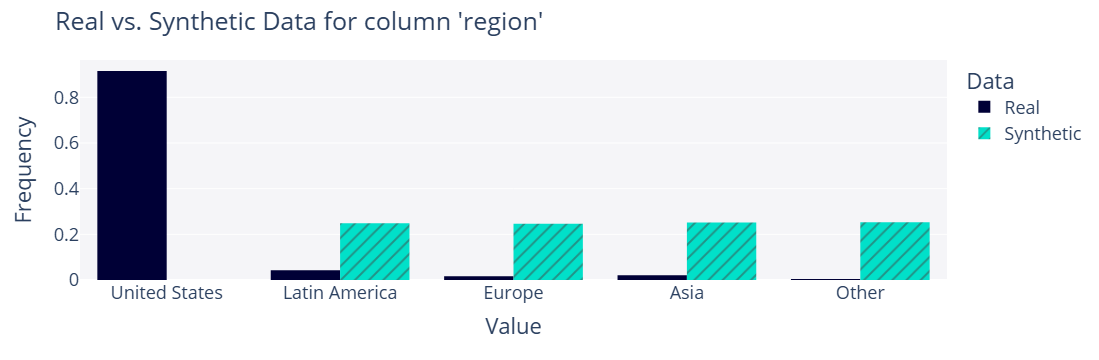

In [72]:
from sdv.evaluation.single_table import run_diagnostic, evaluate_quality
from sdv.evaluation.single_table import get_column_plot

# 1. perform basic validity checks
diagnostic = run_diagnostic(data_filtered, synthetic_data, metadata)

# 2. measure the statistical similarity
quality_report = evaluate_quality(data_filtered, synthetic_data, metadata)

# 3. plot the data
fig = get_column_plot(
    real_data=data_filtered,
    synthetic_data=synthetic_data,
    metadata=metadata,
    column_name='region'
)
    
fig.show()

### The resulting dataset is way more balanced now

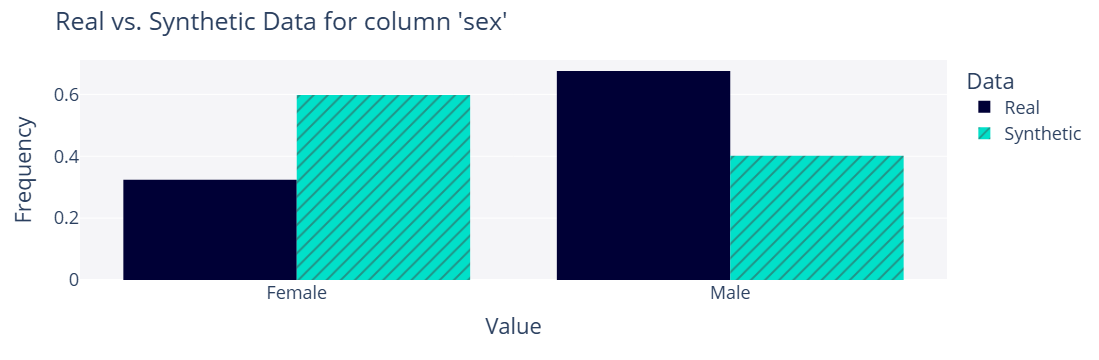

In [73]:
from sdv.evaluation.single_table import get_column_plot

fig = get_column_plot(
    real_data=data_filtered,
    synthetic_data=synthetic_data,
    metadata=metadata,
    column_name='sex'
)
    
fig.show()

In [74]:
#synthetic_data = pd.read_csv('synthetic_simulated_scenario4.csv', encoding='utf-8')  # For UTF-8
augmented_data = pd.concat([data_filtered, synthetic_data]).drop_duplicates()

In [75]:
augmented_data.to_csv("augmented_data.csv", index=False)
print("The DataFrame has been saved as 'augmented_data.csv'.")

The DataFrame has been saved as 'augmented_data.csv'.


In [30]:
#import pickle

# Load the synthesizer with pickle
#with open('my_synthesizer.pkl', 'rb') as f:
    #synthesizer = pickle.load(f)

# Verify the loaded synthesizer
#print(synthesizer)

In [32]:
#augmented_data = pd.read_csv("augmented_data.csv")

## Let's check if there is any inbalance on the "income" column

In [41]:
# Check the unique values and their counts in the "income" column
income_counts = augmented_data["income"].value_counts()

# Display the results
print("Unique values in the 'income' column and their counts:")
print(income_counts)


Unique values in the 'income' column and their counts:
income
<=50K    70485
>50K     14412
Name: count, dtype: int64


## Let's fix this issue by making a random undersample of the majority class

In [34]:
from sklearn.utils import resample

# Separate the majority and minority classes
majority_class = augmented_data[augmented_data['income'] == '<=50K']
minority_class = augmented_data[augmented_data['income'] == '>50K']

# Undersample the majority class to match the minority class
majority_undersampled = resample(
    majority_class,
    replace=False,  # Sample without replacement
    n_samples=len(minority_class),  # Match the number of minority class samples
    random_state=123  # Reproducibility
)

# Combine the undersampled majority class with the minority class
balanced_data = pd.concat([majority_undersampled, minority_class])

# Shuffle the data
balanced_data = balanced_data.sample(frac=1, random_state=123).reset_index(drop=True)

# Save the balanced dataset
balanced_data.to_csv("balanced_augmented_data.csv", index=False)

print("Balanced dataset created with 50/50 distribution. Saved as 'balanced_augmented_data.csv'.")



Balanced dataset created with 50/50 distribution. Saved as 'balanced_augmented_data.csv'.


In [72]:
# Check the unique values and their counts in the "income" column
income_counts = undersampled_data["income"].value_counts()

# Display the results
print("Unique values in the 'income' column and their counts:")
print(income_counts)


Unique values in the 'income' column and their counts:
income
<=50K    14412
>50K     14412
Name: count, dtype: int64


## Now there is no class imbalance


Race Distribution:
 race
White                 19110
Asian-Pac-Islander     6665
Black                  2586
Other                   463
Name: count, dtype: int64

Sex Distribution:
 sex
Male      16235
Female    12589
Name: count, dtype: int64

Region Distribution:
 region
United States    10064
Europe            6025
Asia              5441
Other             3728
Latin America     3566
Name: count, dtype: int64


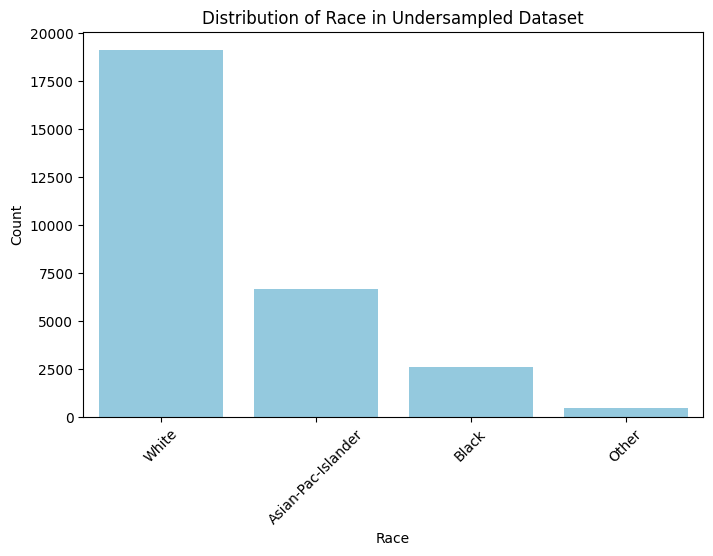

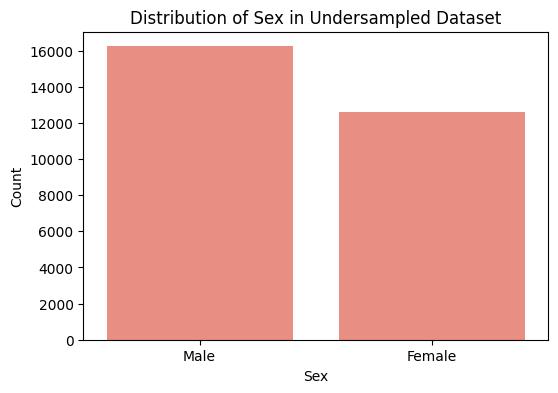

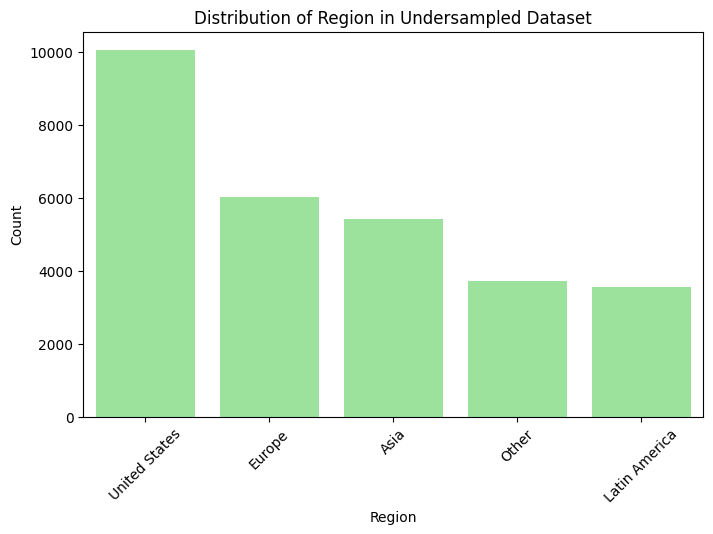

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the new undersampled dataset
undersampled_data = pd.read_csv("balanced_augmented_data.csv")

# Analyze the 'race' column distribution
if 'race' in undersampled_data.columns:
    race = undersampled_data['race']
    race_distribution = race.value_counts()
    print("\nRace Distribution:\n", race_distribution)
else:
    print("\nThe 'race' column is not present. Available columns are:\n", undersampled_data.columns)

# Analyze the 'sex' column distribution
if 'sex' in undersampled_data.columns:
    sex = undersampled_data['sex']
    sex_distribution = sex.value_counts()
    print("\nSex Distribution:\n", sex_distribution)
else:
    print("\nThe 'sex' column is not present. Available columns are:\n", undersampled_data.columns)

# Analyze the 'region' column distribution
if 'region' in undersampled_data.columns:
    region = undersampled_data['region']
    region_distribution = region.value_counts()
    print("\nRegion Distribution:\n", region_distribution)
else:
    print("\nThe 'region' column is not present. Available columns are:\n", undersampled_data.columns)

# Visualize Race Distribution
if 'race' in undersampled_data.columns:
    plt.figure(figsize=(8, 5))
    sns.barplot(x=race_distribution.index, y=race_distribution.values, color="skyblue")
    plt.title('Distribution of Race in Undersampled Dataset')
    plt.xlabel('Race')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

# Visualize Sex Distribution
if 'sex' in undersampled_data.columns:
    plt.figure(figsize=(6, 4))
    sns.barplot(x=sex_distribution.index, y=sex_distribution.values, color="salmon")
    plt.title('Distribution of Sex in Undersampled Dataset')
    plt.xlabel('Sex')
    plt.ylabel('Count')
    plt.show()

# Visualize Region Distribution
if 'region' in undersampled_data.columns:
    plt.figure(figsize=(8, 5))
    sns.barplot(x=region_distribution.index, y=region_distribution.values, color="lightgreen")
    plt.title('Distribution of Region in Undersampled Dataset')
    plt.xlabel('Region')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()


# The visualizations seem good

## Let's now compare both accuricies / selection_rates of each class regarding each sensible feature

In [80]:
# For 'sex' as the sensitive feature
run_fairness_pipeline(undersampled_data, sensitive_feature="sex")

Sensitive Feature: sex, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: sex, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: sex, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: sex, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: sex, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: sex, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: sex, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: sex, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: sex, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: sex, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: sex, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: sex, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Featur

In [81]:
# For 'race' as the sensitive feature
run_fairness_pipeline(undersampled_data, sensitive_feature="race")

Sensitive Feature: race, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: race, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: race, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: race, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: race, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: race, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: race, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: race, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: race, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: race, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: race, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: race, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sens

In [82]:
# For 'region' as the sensitive feature
run_fairness_pipeline(undersampled_data, sensitive_feature="region")

Sensitive Feature: region, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: region, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: region, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: region, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: region, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: region, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: region, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: region, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: region, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: region, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: region, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: region, DP diff: 0.0000, accuracy: 0.0000, sel

# Comparing results:
## Before vs after data augmentation:

## Conclusion for this approach:

### The fairness interventions had mixed results across sensitive features. For sex, the DP difference improved significantly, reducing disparity, but accuracy dropped as a trade-off, indicating fairness at the cost of performance. For region, DP difference worsened, and selection rates became imbalanced, suggesting the intervention failed to ensure fairness across regions despite maintaining accuracy. For race, the DP difference increased, highlighting worsened disparities, though selection rates became more inclusive overall. While the dataset became more inclusive in some cases, these interventions often compromised accuracy and fairness inconsistently across groups, underscoring the need for better-balanced fairness strategies.

# Let's try another approach

In [9]:
data2 = pd.read_csv("adult_preprocessed.csv")

In [12]:
from sdv.metadata import Metadata

metadata = Metadata.detect_from_dataframe(
    data=data2)

In [13]:
from sdv.single_table import TVAESynthesizer

synthesizer = TVAESynthesizer(metadata)
synthesizer.fit(data2)
synthesizer.save(
    filepath='my_synthesizerTVAE.pkl'
)

C:\Users\Rafa Parkoureiro\anaconda3\envs\IAS\Lib\site-packages\sdv\single_table\base.py:104: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


## Let's just create more entries for all the regions other then "united states" because it already has too many.
### Let's also make sure that 70% of this new synthetic data has *income '>50k'*

In [69]:
from sdv.sampling import Condition

# Adjusted conditions to favor income >=50K for all regions
conditions = []

# Proportion settings
income_high_proportion = 0.7  # 70% for income >=50K
income_low_proportion = 0.3  # 30% for income <=50K

# Define total population per region (replace with actual totals if necessary)
region_totals = {
    'Asia': 7000,
    'Europe': 7000,
    'Latin America': 7000,
    'Other': 7000
}

# Generate conditions for all regions
for region, total in region_totals.items():
    # Add conditions for income >=50K
    conditions.append(
        Condition(
            num_rows=int(income_high_proportion * total),
            column_values={'region': region, 'income': '>50K'}
        )
    )
    # Add conditions for income <=50K
    conditions.append(
        Condition(
            num_rows=int(income_low_proportion * total),
            column_values={'region': region, 'income': '<=50K'}
        )
    )

# Generate synthetic data
synthetic_data = synthesizer.sample_from_conditions(
    conditions=conditions,
    max_tries_per_batch=1000,
    output_file_path='syntheticzini.csv'
)


Sampling conditions:  84%|██████████████████████████████████████████████         | 23459/28000 [06:16<01:12, 62.23it/s]
C:\Users\Rafa Parkoureiro\anaconda3\envs\IAS\Lib\site-packages\sdv\single_table\utils.py:154: UserWarning:

Only able to sample 23459 rows for the given conditions. To sample more rows, try increasing `max_tries_per_batch` (currently: 1000). Note that increasing this value will also increase the sampling time.



In [79]:
augmented_income = pd.concat([data2, synthetic_data]).reset_index(drop=True)
augmented_income

age         workclass  education.num      marital.status  \
0       82           Private              9             Widowed   
1       54           Private              4            Divorced   
2       41           Private             10           Separated   
3       34           Private              9            Divorced   
4       38           Private              6           Separated   
...    ...               ...            ...                 ...   
53616   44  Self-emp-not-inc              9             Widowed   
53617   27         State-gov             10       Never-married   
53618   55           Private             13       Never-married   
53619   29           Private             10  Married-civ-spouse   
53620   18           Private             10       Never-married   

              occupation   relationship                race     sex  \
0        Exec-managerial  Not-in-family               White  Female   
1      Machine-op-inspct      Unmarried               White  Female   
2         Prof-specialty      Own-child               White  Female   
3          Other-service      Unmarried               White  Female   
4           Adm-clerical      Unmarried               White    Male   
...                  ...            ...                 ...     ...   
53616      Other-service      Unmarried  Asian-Pac-Islander  Female   
53617     Prof-specialty  Not-in-family  Asian-Pac-Islander    Male   
53618    Exec-managerial  Not-in-family  Asian-Pac-Islander    Male   
53619      Other-service           Wife  Asian-Pac-Islander  Female   
53620    Exec-managerial      Unmarried  Asian-Pac-Islander  Female   

       hours.per.week income         region  
0                  18  <=50K  United States  
1                  40  <=50K  United States  
2                  40  <=50K  United States  
3                  45  <=50K  United States  
4                  40  <=50K  United States  
...               ...    ...            ...  
53616              51  <=50K          Other  
53617              35  <=50K          Other  
53618              40  <=50K          Other  
53619              14  <=50K          Other  
53620              11  <=50K          Other  

[53621 rows x 11 columns]

### Let's add the remaining 4k entries for "Other" with income >50k, which SDV couldn't complete because there were not much examples learned with that configuration

In [80]:
# Check if the required columns exist
if 'region' in augmented_income.columns and 'income' in augmented_income.columns:
    # Filter rows for Other with income > 50K
    other_above_50k = augmented_income[(augmented_income['region'] == 'Other') & (augmented_income['income'] == '>50K')]
    
    # Check if there are enough rows to duplicate
    if len(other_above_50k) > 0:
        # Randomly sample with replacement to create 4,000 new rows
        new_rows = other_above_50k.sample(n=4000, replace=True, random_state=42)
        
        # Append the new rows to the dataset
        augmented_income = pd.concat([augmented_income, new_rows]).reset_index(drop=True)
        print("Added 4,000 rows with income > 50K for the Other region.")
    else:
        print("No rows available to duplicate for the Other region with income > 50K.")
else:
    print("The required columns 'region' or 'income' are not present in the dataset.")


Added 4,000 rows with income > 50K for the Other region.



Race Distribution:
 race
White                 39676
Asian-Pac-Islander    13380
Black                  3174
Other                  1391
Name: count, dtype: int64

Sex Distribution:
 sex
Male      40428
Female    17193
Name: count, dtype: int64

Region Distribution:
 region
United States    27611
Latin America     8297
Asia              7634
Europe            7493
Other             6586
Name: count, dtype: int64


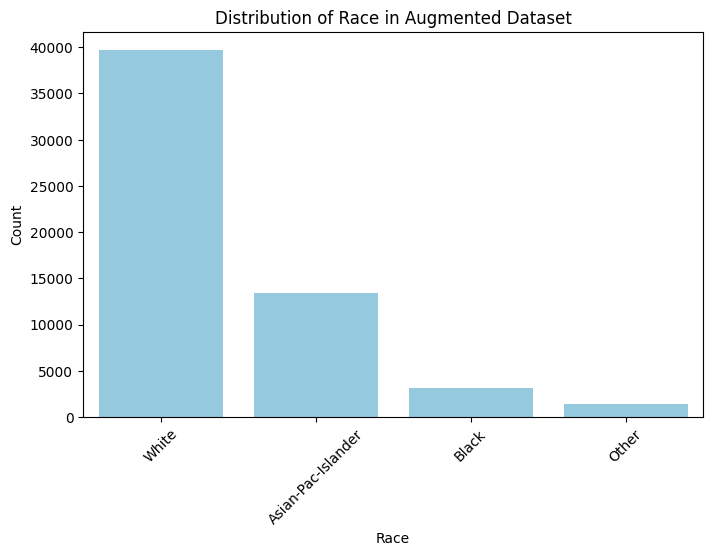

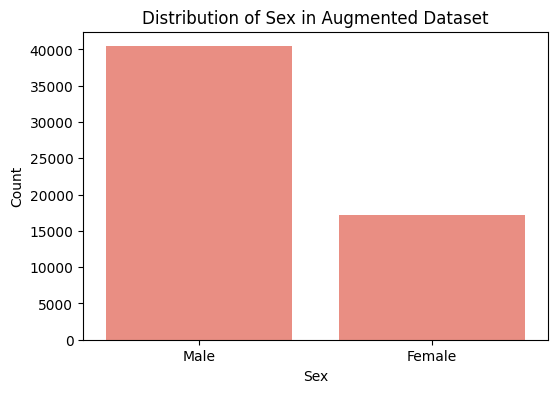

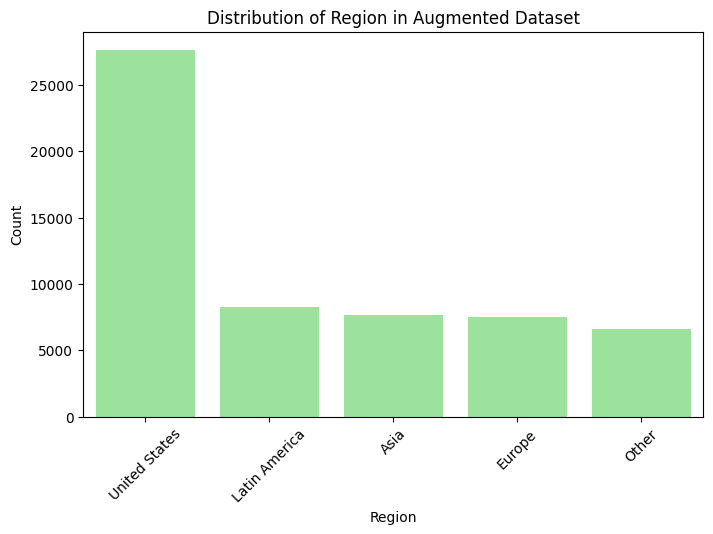

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Analyze the 'race' column distribution
if 'race' in augmented_income.columns:
    race = augmented_income['race']
    race_distribution = race.value_counts()
    print("\nRace Distribution:\n", race_distribution)
else:
    print("\nThe 'race' column is not present. Available columns are:\n", augmented_income.columns)

# Analyze the 'sex' column distribution
if 'sex' in augmented_income.columns:
    sex = augmented_income['sex']
    sex_distribution = sex.value_counts()
    print("\nSex Distribution:\n", sex_distribution)
else:
    print("\nThe 'sex' column is not present. Available columns are:\n", augmented_income.columns)

# Analyze the 'region' column distribution
if 'region' in augmented_income.columns:
    region = augmented_income['region']
    region_distribution = region.value_counts()
    print("\nRegion Distribution:\n", region_distribution)
else:
    print("\nThe 'region' column is not present. Available columns are:\n", augmented_income.columns)

# Visualize Race Distribution
if 'race' in augmented_income.columns:
    plt.figure(figsize=(8, 5))
    sns.barplot(x=race_distribution.index, y=race_distribution.values, color="skyblue")
    plt.title('Distribution of Race in Augmented Dataset')
    plt.xlabel('Race')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

# Visualize Sex Distribution
if 'sex' in augmented_income.columns:
    plt.figure(figsize=(6, 4))
    sns.barplot(x=sex_distribution.index, y=sex_distribution.values, color="salmon")
    plt.title('Distribution of Sex in Augmented Dataset')
    plt.xlabel('Sex')
    plt.ylabel('Count')
    plt.show()

# Visualize Region Distribution
if 'region' in augmented_income.columns:
    plt.figure(figsize=(8, 5))
    sns.barplot(x=region_distribution.index, y=region_distribution.values, color="lightgreen")
    plt.title('Distribution of Region in Augmented Dataset')
    plt.xlabel('Region')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()


### Compared to the previous approach, this one is way more realistic in the study-case scenario, specially regarding region ( there are more people competing to get in the highscools in NYC originated from united states then from other regions )

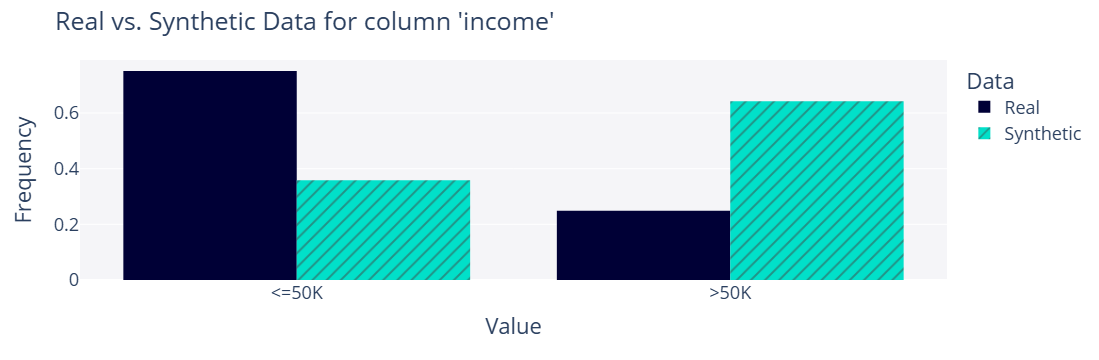

In [72]:
from sdv.evaluation.single_table import get_column_plot

fig = get_column_plot(
    real_data=data2,
    synthetic_data=synthetic_data,
    metadata=metadata,
    column_name='income'
)
    
fig.show()

In [93]:
from sdv.evaluation.single_table import run_diagnostic, evaluate_quality
from sdv.evaluation.single_table import get_column_plot

# 1. perform basic validity checks
diagnostic = run_diagnostic(data2, synthetic_data, metadata)

# 2. measure the statistical similarity
quality_report = evaluate_quality(data2, synthetic_data, metadata)

Generating report ...

(1/2) Evaluating Data Validity: |████████████████████████████████████████████████████| 11/11 [00:00<00:00, 459.29it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |█████████████████████████████████████████████████████| 1/1 [00:00<00:00, 996.75it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%

Generating report ...

(1/2) Evaluating Column Shapes: |████████████████████████████████████████████████████| 11/11 [00:00<00:00, 159.56it/s]|
Column Shapes Score: 72.7%

(2/2) Evaluating Column Pair Trends: |███████████████████████████████████████████████| 55/55 [00:00<00:00, 120.22it/s]|
Column Pair Trends Score: 57.13%

Overall Score (Average): 64.91%



In [94]:
# Check the unique values and their counts in the "income" column
income_counts = augmented_income["income"].value_counts()

# Display the results
print("Unique values in the 'income' column and their counts:")
print(income_counts)


Unique values in the 'income' column and their counts:
income
<=50K    31054
>50K     26567
Name: count, dtype: int64


In [95]:
# Check if the necessary columns exist
if 'region' in augmented_income.columns and 'income' in augmented_income.columns:
    # Count rows grouped by region and income
    income_region_distribution = augmented_income.groupby(['region', 'income']).size().reset_index(name='count')
    print("\nNumber of rows with income by region:")
    print(income_region_distribution)
else:
    print("\nThe columns 'region' or 'income' are not present. Available columns are:\n", augmented_income.columns)



Number of rows with income by region:
          region income  count
0           Asia  <=50K   2531
1           Asia   >50K   5103
2         Europe  <=50K   2444
3         Europe   >50K   5049
4  Latin America  <=50K   3290
5  Latin America   >50K   5007
6          Other  <=50K   2209
7          Other   >50K   4377
8  United States  <=50K  20580
9  United States   >50K   7031


### To keep the ratio, let's take out 15k entries from united states which receive less or equal then 50k

In [85]:
# Check if the required columns exist
if 'region' in augmented_income.columns and 'income' in augmented_income.columns:
    # Filter rows for United States with income <= 50K
    us_below_50k = augmented_income[(augmented_income['region'] == 'United States') & (augmented_income['income'] == '<=50K')]
    
    # Check if there are enough rows to remove
    if len(us_below_50k) >= 15000:
        # Randomly sample 15,000 rows
        rows_to_remove = us_below_50k.sample(n=15000, random_state=42).index
        
        # Drop these rows from the dataset
        augmented_income_no_usa = augmented_income.drop(rows_to_remove).reset_index(drop=True)
        print("Removed 15,000 rows with income <= 50K for the United States.")
    else:
        print(f"Not enough rows to remove. Available: {len(us_below_50k)}")
else:
    print("The required columns 'region' or 'income' are not present in the dataset.")


Removed 15,000 rows with income <= 50K for the United States.


In [87]:
# Check if the necessary columns exist
if 'region' in augmented_income.columns and 'income' in augmented_income.columns:
    # Count rows grouped by region and income
    income_region_distribution = augmented_income_no_usa.groupby(['region', 'income']).size().reset_index(name='count')
    print("\nNumber of rows with income by region:")
    print(income_region_distribution)
else:
    print("\nThe columns 'region' or 'income' are not present. Available columns are:\n", augmented_income.columns)


Number of rows with income by region:
          region income  count
0           Asia  <=50K   2531
1           Asia   >50K   5103
2         Europe  <=50K   2444
3         Europe   >50K   5049
4  Latin America  <=50K   3290
5  Latin America   >50K   5007
6          Other  <=50K   2209
7          Other   >50K   4377
8  United States  <=50K   5580
9  United States   >50K   7031


In [126]:
augmented_income_no_usa.to_csv('augmented_income_no_usa.csv', index=False)


## Now the dataset is way more balanced, without loosing its information totally

In [86]:
run_fairness_pipeline(augmented_income_no_usa, sensitive_feature="region")

Sensitive Feature: region, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: region, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: region, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: region, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: region, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: region, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: region, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: region, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: region, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: region, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: region, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: region, DP diff: 0.0000, accuracy: 0.0000, sel

In [88]:
run_fairness_pipeline(augmented_income_no_usa, sensitive_feature="sex")

Sensitive Feature: sex, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: sex, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: sex, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: sex, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: sex, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: sex, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: sex, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: sex, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: sex, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: sex, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: sex, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: sex, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Featur

In [89]:
run_fairness_pipeline(augmented_income_no_usa, sensitive_feature="race")

Sensitive Feature: race, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: race, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: race, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: race, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: race, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: race, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: race, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: race, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: race, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: race, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: race, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sensitive Feature: race, DP diff: 0.0000, accuracy: 0.0000, selection_rate: 0.0000
Sens

## Let's compare this approach to the original dataset:

# Conclusions:

## The new fairness interventions show significant improvement across the three sensitive features, reducing disparities and making the model outcomes fairer for society. 
- For sex, the DP difference increased slightly from 0.0760 to 0.1103, but selection rates became much more balanced between males and females, indicating improved inclusivity despite a drop in accuracy.
- For region, the DP difference decreased substantially from 0.3265 to 0.1150, and selection rates became more uniform across regions, demonstrating a notable reduction in bias while maintaining reasonable accuracy.
-  For race, the DP difference improved slightly from 0.0804 to 0.0649, with significantly higher and more balanced selection rates across racial groups, ensuring a fairer distribution of outcomes.
### This approach successfully reduces bias and creates more equitable outcomes, aligning better with societal fairness objectives by ensuring underrepresented groups receive more favorable treatment.

## 1st approach VS. 2nd approach

- **Metrics Differences: In the second approach, the DP difference consistently improved (or remained reasonable), selection rates became more balanced across groups, and accuracy was maintained at acceptable levels despite the fairness interventions. This contrasted with the first approach, which showed uneven changes in these metrics, with some sensitive features experiencing worsened disparities.**

- **Impacts to Society: The second approach promotes more equitable decision-making, ensuring that outcomes are distributed fairly across underrepresented groups, which helps reduce systemic biases and creates a more inclusive and just societal impact.**

C:\Users\Rafa Parkoureiro\anaconda3\envs\IAS\Lib\site-packages\xgboost\core.py:158: UserWarning:

[19:44:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




Accuracy: 0.8609
Precision: 0.8509
Recall: 0.9419
F1 Score: 0.8941


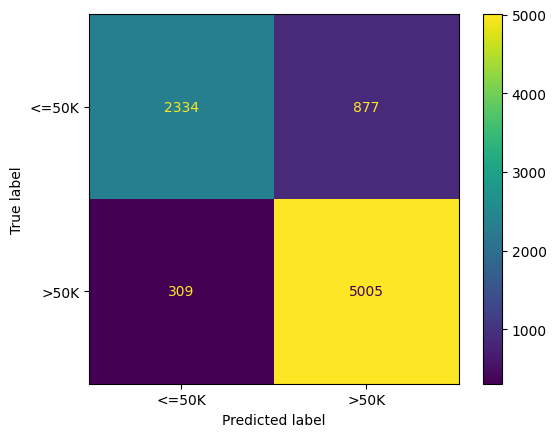


Classification Report:
              precision    recall  f1-score   support

       <=50K       0.88      0.73      0.80      3211
        >50K       0.85      0.94      0.89      5314

    accuracy                           0.86      8525
   macro avg       0.87      0.83      0.85      8525
weighted avg       0.86      0.86      0.86      8525



In [121]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, confusion_matrix, ConfusionMatrixDisplay,
    precision_score, recall_score, f1_score, classification_report
)
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# Prepare the data
X = augmented_income_no_usa.drop(columns=["income"])  # Replace 'income' with your target column name
y = augmented_income_no_usa["income"]

# Convert target labels to numeric
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)  # '<=50K' -> 0, '>50K' -> 1

# Identify categorical columns
categorical_columns = X.select_dtypes(include=["object", "category"]).columns

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="if_binary", sparse_output=False), categorical_columns),
    ],
    remainder="passthrough"  # Leave other columns (numerical) as is
)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Create a pipeline with preprocessing and model
pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", XGBClassifier(
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            random_state=42,
            use_label_encoder=False,
            eval_metric="logloss"
        )),
    ]
)

# Train the model
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_encoder.classes_)
disp.plot()
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


# Let's try using LIME to give us some explainability 

In [130]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import lime
import lime.lime_tabular

# Load the dataset

# Split features and target
X = augmented_income_no_usa.drop(columns=['income'])
y = augmented_income_no_usa['income']

categorical_cols = X.select_dtypes(include=['object']).columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

# Encode the target variable
target_encoder = LabelEncoder()
y = target_encoder.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a simple Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Test the model
accuracy = model.score(X_test, y_test)
print(f"Model accuracy: {accuracy:.2f}")

# Find a test sample with a true label of '>50K'
true_label_index = np.where(y_test == target_encoder.transform(['>50K'])[0])[0][0]  # Get the first index with '>50K'
sample = X_test.iloc[true_label_index]
true_label = y_test[true_label_index]

# Set up LIME
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X.columns,
    class_names=target_encoder.classes_,
    mode='classification'
)

# Explain the prediction
exp = explainer.explain_instance(
    data_row=sample.values,
    predict_fn=model.predict_proba,
    num_features=10  # Adjust number of top features shown
)

# Print explanation
print(f"True label: {target_encoder.inverse_transform([true_label])[0]}")
exp.show_in_notebook(show_table=True)

# Optional: Save explanation as an HTML file
exp.save_to_file("lime_explanation_with_labelencoder.html")


Model accuracy: 0.85
True label: >50K


C:\Users\Rafa Parkoureiro\anaconda3\envs\IAS\Lib\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names

